In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as sp

In [2]:
df = pd.read_csv('daten.csv', header=None)

#change type of first column to datetime and right format
df[0] = pd.to_datetime(df[0])
df[0] = df[0].dt.strftime("%d-%m-%Y")
df[0] = pd.to_datetime(df[0])

#change from string to numeric value
df[1] = df[1].str.replace(',', '.')
df[1] = pd.to_numeric(df[1])
df

,0,1
0,2020-01-01,3052.89738
1,2020-01-02,3210.74493
2,2020-01-03,2441.95893
3,2020-01-04,37457.50944
4,2020-01-05,3768.72306
...,...,...
361,2020-12-27,3210.74538
362,2020-12-28,2441.95938
363,2020-12-29,37457.50989
364,2020-12-30,3768.72351


In [4]:
value = df[0][360]

print(value.year,
value.month,
value.quarter,
value.day)

2020 12 4 26


In [6]:
#read prices and change type to numeric
prices = pd.read_csv('preise.csv', header=None)
prices.iloc[:, 1:] = prices.iloc[:, 1:].applymap(lambda x: pd.to_numeric(x.replace(',', '.')))
prices

,0,1,2,3
0,1,0.425,0.183,0.027
1,1,0.425,0.183,0.027
2,1,0.425,0.175,0.026
3,1,0.250,0.158,0.024
4,1,0.250,0.117,0.019
5,1,0.250,0.100,0.015
6,1,0.250,0.100,0.015
7,1,0.250,0.100,0.015
8,1,0.250,0.117,0.019
9,1,0.425,0.175,0.026


Now we will define our objetive Function. The input should be a list of the parameters and the output the cost of this package combination.

The input list should be of the form [year, q1, q2, q3, q4, m1, ..., m12]

In [15]:
def objective(param):
    
    param_year = param[0]
    param_quarter = param[1:5]
    param_months = param[5:17]
    penalty_months = prices[3]
    
    penalty_list = []

    #calculate dayly costs for whole year
    for day in range(366):
        
        #get demand of this day
        
        this_day, daily_demand = df[0][day], df[1][day]
        
        #get pricing today depending on quarter, month
        quarter = this_day.quarter - 1
        month = this_day.month - 1  # -1 for combatibility with list indexing
        
        #calculate penalty cost of this day
        demand_satisfied = param_year + param_quarter[quarter] + param_months[month]
        missing_demand = max(0, daily_demand - demand_satisfied)
        
        penalty_cost = missing_demand * penalty_months[month]
        
        #save penalty cost in list
        penalty_list.append(penalty_cost)
     
    #calculate total penalty cost and package cost
    total_penalty_cost = sum(penalty_list)
    cost_year = param_year
    cost_quarter = 0.425 * param_quarter[0] + 0.25 * param_quarter[1] + 0.25 * param_quarter[2] + 0.425 * param_quarter[3]
    cost_months = 0
    i = 0
    while i<12:
        cost_months += param_months[i]*prices[2][i]
        i += 1
    
    package_cost = cost_year + cost_quarter + cost_months
    
    total_cost = total_penalty_cost + package_cost
    return total_cost

In [16]:
initial_guess = [1]*17
bnds = tuple([(0, None)]*17)
result = sp.minimize(objective, initial_guess, bounds=bnds)

In [17]:
result

      fun: 39829.63278163788
 hess_inv: <17x17 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 8.73624231e+00,  2.69213279e-02,  1.74624829e-02, -6.33015007e-02,
        1.05502501e-01,  7.49423634e-02,  7.49423639e-02, -7.27595761e-03,
        6.18456397e-02,  4.07453626e-02,  4.00177669e-02, -2.03726652e-02,
        4.00177351e-02, -1.67346892e-02,  7.05767889e-02,  7.49423634e-02,
        7.49423634e-02])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 1278
      nit: 27
     njev: 71
   status: 0
  success: True
        x: array([0.00000000e+00, 4.49343877e+03, 4.50832695e+03, 3.93260712e+03,
       4.49911586e+03, 0.00000000e+00, 4.63846803e+00, 2.54219714e-06,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.43756259e+02,
       5.96011456e+02, 5.16488265e+02, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00])

In [18]:
print( "units_year = " + str(result.x[0]), "\n",
    "units_quarter = " + str(result.x[1:5]),"\n",
    "units_year = " + str(result.x[5:]))

units_year = 0.0 
 units_quarter = [4493.43877164 4508.3269487  3932.60712194 4499.11585982] 
 units_year = [0.00000000e+00 4.63846803e+00 2.54219714e-06 0.00000000e+00
 0.00000000e+00 0.00000000e+00 5.43756259e+02 5.96011456e+02
 5.16488265e+02 0.00000000e+00 0.00000000e+00 0.00000000e+00]


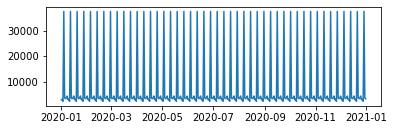

In [14]:
data = df
data = data.set_index(0)

p = plt.subplot(2,1,1)
plt.plot(data[1])
p.set_xlim(pd.Timestamp('2020-01-01'),pd.Timestamp('2020-02-01'))